In [1]:
# This cell expands the cells of the notebook to the width of the window
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Week 4

## Python setup

In [2]:
import json
import math
import matplotlib as mpl
from matplotlib import colormaps
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import random
import re
import urllib.request

## Exercises Prelude: Regular expressions

### 0.1 Tutorial in RegEx
_Honestly, this [youtube](https://www.youtube.com/watch?v=rhzKDrUiJVk) guide is waaaayyyy better than the google guide..._

Regular expressions are a powerful language for matching text patterns.

The Python "re" module provides regular expression support.

In [3]:
# If-statement after search() tests if it succeeded
def check_regex(match):
    if match:
      print('found:', match.group())
    else:
      print('did not find')

In RegEx, we are interested in using a pattern, 'pat', to search through a text, 'str'. The pattern is defined as an regular expression based on a defined syntax. In python's 're' library, each pattern starts with a 'r' followed by the expression. 

_Note that the syntax in python is a bit different than traditional RegEx!_

In [4]:
str = 'purple alice-b@google.com monkey dishwasher'
pat = r'([\w.-]+)@([\w.-]+)'

# The re.search() function returns a match type, which contains groups
match = re.search(pat, str)

check_regex(match)

found: alice-b@google.com


Group Extraction - We can split our result into groups and then extract them separately.

In [5]:
print(match.group(0)) # (the whole match)
print(match.group(1)) # (the username, group 1)
print(match.group(2)) # (the host, group 2)

alice-b@google.com
alice-b
google.com


The most powerful function in re is findall(), which returns a list of regex results. 

In [6]:
## Suppose we have a text with many email addresses
str = 'purple alice@google.com, blah monkey bob@abc.com blah dishwasher'

pat = r'([\w\.-]+@[\w\.-]+)'

## Here re.findall() returns a list of all the found email strings
emails = re.findall(pat, str) ## ['alice@google.com', 'bob@abc.com']

for email in emails:
    # do something with each found email string
    print(email)

alice@google.com
bob@abc.com


The findall function can also be used on files!

In [7]:
# Open file
f = open('../files/hamlet_act_1_scene_1.txt', encoding='utf-8')

# Get only scenographic instructions, marked by '(...)'
pat = r'\(([^)]+)\)'

# Feed the file text into findall(); it returns a list of all the found strings
strings = re.findall(pat, f.read())
strings

['Enter Barnardo and Francisco, two sentinels.',
 'Enter Horatio and Marcellus.']

Findall and Groups can be used to sub divide the search results. 

In [8]:
str = 'purple alice@google.com, blah monkey bob@abc.com blah dishwasher'
pat = r'([\w\.-]+)@([\w\.-]+)'

tuples = re.findall(pat, str)

print(tuples)  ## [('alice', 'google.com'), ('bob', 'abc.com')]

for tuple in tuples:
    print(f"Username: \"{tuple[0]}\", Host: \"{tuple[1]}\"")

[('alice', 'google.com'), ('bob', 'abc.com')]
Username: "alice", Host: "google.com"
Username: "bob", Host: "abc.com"


### 0.2 What are regular expressions

A regular expression is a string, which follows a predefined syntax that enables pattern recognition in texts.

### 0.3 RegEx on 4-digit numbers from URL text

Find all 4-digit numbers in [this text](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/regex_exercise.txt).

In [9]:
# Define the url
url = "https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/regex_exercise.txt"

# Get HTTPResponse from url
data = urllib.request.urlopen(url)

# Extract byte string from reponse data
byte_string = data.read()

# Decode byte string to regular string
text = byte_string.decode("utf-8")

In [10]:
# Get only 4-digit numbers
pat = r'(?<!\d)\d{4}(?!\d)'

# Feed the file text into findall(); it returns a list of all the found strings
numbers = re.findall(pat, text)

# Print digist one at a time on new lines 
print(*numbers, sep="\n")

1234
9999


### 0.4 RegEx for words starting with 'super' from URL text

In [11]:
# Get only words starting with 'super'
pat = r'super[\w+]*'

# Feed the file text into findall(); it returns a list of all the found strings
words = re.findall(pat, text)

# Print digist one at a time on new lines 
print(*words, sep="\n")

superpolaroid
supertaxidermy
superbeer


### 0.5 RegEx find Wiki links in URL text

In [12]:
def find_all_wiki_links(text):
    # Get any strings surrounded by '[[...]]'
    pat = r'\[\[(.*?)\]\]' 
    pat = r'\[\[(?!Category:)(?!File:)(?!Image:)(.*?)\]\]'
    matches = re.findall(pat, text)
    
    # List to hold the final substrings
    results = []
    for match in matches:
        # Remove content in parentheses and split by '|'
        cleaned_substrings = re.sub(r'\s*\(.*?\)\s*', '', match).split('|')
        results.extend(cleaned_substrings)
    
    # Create urls from wiki links one at a time while replacing spaces with '_' 
    urls = []
    for res in results:
        res = res.replace(" ", "_")
        urls.append("https://en.wikipedia.org/wiki/" + res)

    # Remove dublicate results and urls
    results = list(dict.fromkeys(results))
    urls = list(dict.fromkeys(urls))
    
    return urls, results 

# Find all wiki_link urls and print them out
urls, results = find_all_wiki_links(text)

print(f"Results ({len(results)} found):")
print(f"Urls ({len(urls)} found):")
print(*urls, sep="\n")

Results (6 found):
Urls (6 found):
https://en.wikipedia.org/wiki/drinking_vinegar
https://en.wikipedia.org/wiki/gentrify
https://en.wikipedia.org/wiki/hashtag
https://en.wikipedia.org/wiki/Bicycle
https://en.wikipedia.org/wiki/Pitchfork
https://en.wikipedia.org/wiki/Pitchfork_Magazine


## Exercises Part 1: Download the Wikipedia pages of characters

### 1.1 Extract all links into a list of country performers
We use the wikipedia API to fetch the content of the wikipedia page: https://en.wikipedia.org/wiki/List_of_country_music_performers

In [13]:
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
title = "titles=List_of_country_music_performers"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"

query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
print(query)

https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=List_of_country_music_performers&format=json


In [14]:
wikiresponse = urllib.request.urlopen(query)
wikidata = wikiresponse.read()
wikitext = wikidata.decode('utf-8')
json_response = json.loads(wikitext)

In [15]:
# Get the latest page number
page = list(json_response["query"]["pages"].keys())[0]
page

'328877'

In [16]:
# Get text content from page
text = json_response["query"]["pages"][page]["revisions"][0]["*"]

In [17]:
# Find all wiki_link urls and print them out
urls, results = find_all_wiki_links(text)
print(f"Urls ({len(urls)} found):")
print(*urls, sep="\n")

Urls (2112 found):
https://en.wikipedia.org/wiki/country_music
https://en.wikipedia.org/wiki/3_of_Hearts
https://en.wikipedia.org/wiki/4_Runner
https://en.wikipedia.org/wiki/8_Ball_Aitken
https://en.wikipedia.org/wiki/Gene_Autry
https://en.wikipedia.org/wiki/Eddy_Arnold
https://en.wikipedia.org/wiki/Roy_Acuff
https://en.wikipedia.org/wiki/Rodney_Atkins
https://en.wikipedia.org/wiki/The_Abrams_Brothers
https://en.wikipedia.org/wiki/Ace_in_the_Hole_Band
https://en.wikipedia.org/wiki/Kay_Adams
https://en.wikipedia.org/wiki/Ryan_Adams
https://en.wikipedia.org/wiki/Doug_Adkins
https://en.wikipedia.org/wiki/Trace_Adkins
https://en.wikipedia.org/wiki/David_"Stringbean"_Akeman
https://en.wikipedia.org/wiki/Rhett_Akins
https://en.wikipedia.org/wiki/Alabama
https://en.wikipedia.org/wiki/Lauren_Alaina
https://en.wikipedia.org/wiki/Jason_Aldean
https://en.wikipedia.org/wiki/Alee
https://en.wikipedia.org/wiki/Daniele_Alexander
https://en.wikipedia.org/wiki/Jessi_Alexander
https://en.wikipedia.org/w

### 1.2 Download the content of each wiki link and save them to a text file

In [18]:
# Folder to store the text files
cwd = os.getcwd()
folder_name = "wiki_text"
folder_path = os.path.join(cwd, folder_name)
folder_path

'C:\\Users\\Aleksandar Lukic\\School\\02805_Social_Graphs_and_Interactions\\Exercise_solutions\\wiki_text'

In [19]:
# Check if the folder exists, otherwise create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [20]:
def get_result_content(result):
    # Create query using wikipedia's API
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    
    # Add '_' for proper url format
    result = result.replace(" ", "_")
    
    # Use urllib.parse.quote to encode special characters
    title = f"titles={urllib.parse.quote(result)}"
    
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    
    # Get http response from query and decode it
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    json_response = json.loads(wikitext)
    
    # Find latest page and fetch content
    page = list(json_response["query"]["pages"].keys())[0]
    
    # The name gave no hits nor redirects
    if page == '-1':
        return -1
    
    url_content = json_response["query"]["pages"][page]["revisions"][0]["*"]
    
    # Check if the name is redirected, in which case return redirected result
    redirect = re.findall(r'(?<=#redirect )\[\[(.*?)\]\]', url_content)
    if redirect:
        return get_result_content(redirect[0])
    
    return url_content

In [21]:
def save_wikitext_to_txt(name):
    # Artist name becomes the name of the .txt file
    file_name = name

    # Pre-cleans artist name so the file does not get corrupted 
    file_name = re.sub(r'[^a-zA-Z0-9]', '_', file_name) + ".txt"
    
    # File path to where the file will be stored
    file_path = os.path.join(folder_path, file_name)
    
    content = get_result_content(name)
    
    # The name gave no hits nor redirects
    if content == -1:
        return -1
    
    # Create/open file and write content from url
    with open(file_path,'w',encoding='utf-8') as file :
        file.write(content.encode('utf-8').decode('utf-8'))
        file.close()

In [22]:
# Save txt file for every artist in the list
for name in results:
    # Check if file already exists
    name_txt = re.sub(r'[^a-zA-Z0-9]', '_', name) + ".txt"
    if not os.path.exists(os.path.join(folder_path, name_txt)):    
        # The artist name did not lead to any wiki page
        if get_result_content(name)==-1:
            results.remove(name)
        else:
            save_wikitext_to_txt(name)

In [23]:
# Check folder content and print list of files
folder_content = os.listdir(folder_path)
i = 1
for file in folder_content:
    print(f"{i}: {file}")
    i = i+1

1: 3_of_Hearts.txt
2: 4_Runner.txt
3: 8_Ball_Aitken.txt
4: Aaron_Barker.txt
5: Aaron_Benward.txt
6: Aaron_Lewis.txt
7: Aaron_Lines.txt
8: Aaron_Neville.txt
9: Aaron_Pritchett.txt
10: Aaron_Tippin.txt
11: Aaron_Watson.txt
12: Ace_in_the_Hole_Band.txt
13: Adam_Brand.txt
14: Adam_Craig.txt
15: Adam_Gregory.txt
16: Adam_Harvey.txt
17: Adam_Hood.txt
18: Adrienne_Young.txt
19: Alabama.txt
20: Alan_Jackson.txt
21: Alecia_Elliott.txt
22: Alecia_Nugent.txt
23: Alee.txt
24: Aleyce_Simmonds.txt
25: Alisan_Porter.txt
26: Alison_Krauss.txt
27: Allison_Moorer.txt
28: Allison_Russell.txt
29: Alli_Walker.txt
30: Allman_Brothers_Band.txt
31: Alyssa_Micaela.txt
32: Al_Anderson.txt
33: Al_Caiola.txt
34: Al_Dexter.txt
35: Al_Downing.txt
36: Al_Hurricane.txt
37: Al_Hurricane_Jr_.txt
38: Amanda_Shires.txt
39: Amanda_Stott.txt
40: Amanda_Wilkinson.txt
41: Amazing_Rhythm_Aces.txt
42: Amber_Dotson.txt
43: Amber_Hayes.txt
44: Amber_Lawrence.txt
45: American_Young.txt
46: Amie_Comeaux.txt
47: Amy_Dalley.txt
48: 

## Exercises Part 2: Building the networks

### 2.1 Build network based on txt files

In [24]:
# Remove any artist which did not lead to any wiki page
# and update results accordingly
folder_content = os.listdir(folder_path)
new_results = []
for file_name in folder_content:
    for res in results:
        res_name = re.sub(r'[^a-zA-Z0-9]', '_', res) + ".txt"
        if file_name == res_name:
            new_results.append(res)
            continue
            
# Update results in the same order as the file directory
results = new_results

In [25]:
# # If needed, manually check if the two lists are alligned:
# for i in range(len(results)):
#     print(f"[{results[i]}, {folder_content[i]}]")

In [26]:
def get_all_outgoing_links_as_list(file_content):
    # Find all wiki_link urls and print them out
    file_urls, file_results = find_all_wiki_links(file_content)

    # Extract links which are in both the artists wiki as well as in the list of artists
    links = [link for link in file_results if link in results]
    
    return links

In [27]:
# Create list of outgoing link neighbours
list_of_link_lists = []
for txt_file in folder_content:
    # Create file path
    file_path = os.path.join(folder_path, txt_file)
    
    # load text from .txt file
    with open(file_path, 'r', encoding='utf-8') as file:
        file_content = file.read()

    link_list = get_all_outgoing_links_as_list(file_content)
    list_of_link_lists.append(link_list)

In [28]:
# Create dictonary to join artist with outgoing links
keys = results
values = list_of_link_lists
dict_of_link_lists = dict(zip(keys, values))

In [29]:
# Create dictonary to join artist with txt file
keys = results
values = folder_content
dict_of_txt_files = dict(zip(keys, values))

In [30]:
# Function to count the number of words in the wiki content from a txt file
def get_length_of_the_content(txt_file):
    # Create file path
    file_path = os.path.join(folder_path, txt_file)
    
    # load text from .txt file
    with open(file_path, 'r', encoding='utf-8') as file:
        file_content = file.read()
    
    pat = r'\w+'
    words = re.findall(pat, file_content)
    
    return len(words)

We initialise our graph with a node for each artist in the result list

In [31]:
G = nx.DiGraph()

# Add a node for each artist and then add all outgoing links
for k, v in dict_of_link_lists.items():
    G.add_node(
        k, 
        txt_file = dict_of_txt_files[k],
        length_of_content = get_length_of_the_content(dict_of_txt_files[k])
    )
    G.add_edges_from([(k,n) for n in v])

In [32]:
print(G)

DiGraph with 2106 nodes and 18737 edges


In [33]:
# Show attributes of each node
for attrs in G.nodes().data():
    print(attrs)

('3 of Hearts', {'txt_file': '3_of_Hearts.txt', 'length_of_content': 646})
('country music', {'txt_file': 'country_music.txt', 'length_of_content': 30455})
('4 Runner', {'txt_file': '4_Runner.txt', 'length_of_content': 2538})
('Tanya Tucker', {'txt_file': 'Tanya_Tucker.txt', 'length_of_content': 6289})
('Diamond Rio', {'txt_file': 'Diamond_Rio.txt', 'length_of_content': 10259})
('Reba McEntire', {'txt_file': 'Reba_McEntire.txt', 'length_of_content': 21253})
('Amie Comeaux', {'txt_file': 'Amie_Comeaux.txt', 'length_of_content': 889})
('Michael Johnson', {'txt_file': 'Michael_Johnson.txt', 'length_of_content': 723})
('Poco', {'txt_file': 'Poco.txt', 'length_of_content': 120})
('Great Plains', {'txt_file': 'Great_Plains.txt', 'length_of_content': 12179})
('Chely Wright', {'txt_file': 'Chely_Wright.txt', 'length_of_content': 12657})
('Keith Urban', {'txt_file': 'Keith_Urban.txt', 'length_of_content': 10905})
('Chad Brock', {'txt_file': 'Chad_Brock.txt', 'length_of_content': 2020})
('The Je

In [34]:
# Extract the largest connected component
largest_cc = max(nx.weakly_connected_components(G), key=len)

# Create new graph from largest connected component
S = G.subgraph(largest_cc).copy()

In [35]:
# nx.draw(
#     S, 
#     with_labels=False, 
#     node_size=10, 
#     width=0.1, 
#     node_color = "darkblue" 
# )

### 2.2 Simple network statistics and analysis *
#### Simple network statistics and analysis
For the following calculations, graphs, statistics etc. the largest connected component was used.

> Note: Since 'country music' does not refer to an artist but the genre itself, we will manually remove it from the network:

In [36]:
S.remove_node('country music')

##### 2.2.1 What is the number of nodes in the network?

From the below code, we got 2000 nodes. (_When including the genre: 2001 nodes_)

In [37]:
no_nodes = len(S.nodes())
no_nodes

2003

##### 2.2.2 What is the number of links?

From the below code, we got 17173 edges. (_When including the genre: 18683 edges_)

In [38]:
no_edges = len(S.edges())
no_edges

17181

##### 2.2.3 Plot the in and out-degree distributions for the entire network.

In [39]:
# sort nodes after in/out-degree
S_sorted_in_degree = sorted(S.in_degree, key=lambda x: x[1], reverse=True)
S_sorted_out_degree = sorted(S.out_degree, key=lambda x: x[1], reverse=True)

In [40]:
# Extract in/out-degree from nodes and store separately
S_in_degree_values = [x[1] for x in S_sorted_in_degree]
S_out_degree_values = [x[1] for x in S_sorted_out_degree]

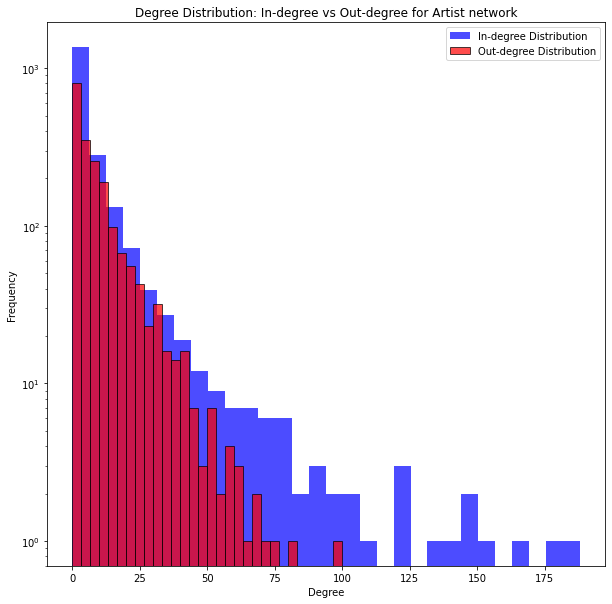

In [41]:
# Set size of figure
plt.figure(figsize=(10, 10))

# Histogram of In-degree Distribution
plt.hist(
    S_in_degree_values, 
    bins=30, 
    alpha=0.7, 
    label="In-degree Distribution", 
    color="blue"
)

# Histogram of Out-degree Distribution
plt.hist(
    S_out_degree_values, 
    bins=30, 
    alpha=0.7, 
    label="Out-degree Distribution", 
    color="red",
    edgecolor="black"
)

# Settings of axis/plot
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')
plt.legend()
plt.title("Degree Distribution: In-degree vs Out-degree for Artist network")
plt.show()

#### Visual analysis of degree distributions
The histogram is plotted on a logarithmic scale and shows the frequency of nodes with a given degree. 

There is a characteristic heavy tail on the in-degree distribution. This suggests the presence of some very high in-degree nodes. These are highly referenced artist pages, such as Johnny Cash and Dolly Parton. 

The out-degree distribution is slightly more constrained to the 'lower' degrees. This might be due to most artist's pages focusing primarily on the artist’s own biography and career. This would in return limit the number of outgoing links, leading to a relatively lower out-degree distribution.

#### Compare degree distributions to randomly generated network
We start by generating a random network with nodes and edges equal to that of the country artists network.

In [42]:
# Create a random directed graph with n nodes and e edges
RG = nx.gnm_random_graph(no_nodes, no_edges, directed=True)

In [43]:
# sort nodes after in/out-degree
RG_sorted_in_degree = sorted(RG.in_degree, key=lambda x: x[1], reverse=True)
RG_sorted_out_degree = sorted(RG.out_degree, key=lambda x: x[1], reverse=True)

In [44]:
# Extract in/out-degree from nodes and store separately
RG_in_degree_values = [x[1] for x in RG_sorted_in_degree]
RG_out_degree_values = [x[1] for x in RG_sorted_out_degree]

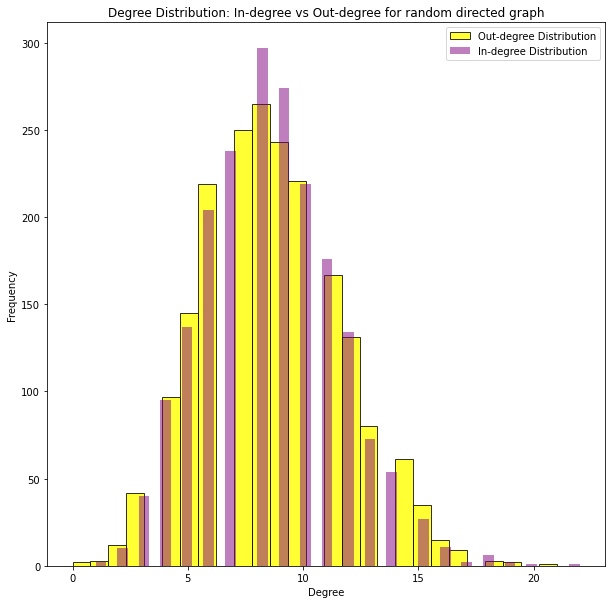

In [45]:
# Set size of figure
plt.figure(figsize=(10, 10))

# The random directed graph
# Histogram of Out-degree Distribution
plt.hist(
    RG_out_degree_values, 
    bins='auto', 
    alpha=0.8, 
    label="Out-degree Distribution", 
    color="yellow",
    edgecolor="black"
)

# Histogram of In-degree Distribution
plt.hist(
    RG_in_degree_values, 
    bins='auto', 
    alpha=0.5, 
    label="In-degree Distribution", 
    color="purple"
)

# Settings of axis/plot
plt.xlabel("Degree")
plt.ylabel("Frequency")
# plt.yscale('log')
plt.legend()
plt.title("Degree Distribution: In-degree vs Out-degree for random directed graph")
plt.show()

By comparing the out-degree distributions of the two histograms, it is clear there is a differnce.

While random networks are said to follow a Poisson distribution centered around the mean degree, real networks do not follow this behaviour. 

Real networks are often said to follow a power-law distribution, where most of the nodes have very few links, i.e. small degree, while a small number of nodes, called hubs, have a very large number of links, i.e. high degree. 

This goes is visually demonstrated by the heavy tail observed in the artist netwok's degree distributions. 

#### Compare degree distributions to scale-free network
We start by generating a scale-free network with nodes and edges equal to that of the country artists network.

In [46]:
# Calculate the number of edges to attach from a new node to existing nodes.
# Ensure m is at least 1 so each node is connected to at least one other node
m = max(1, math.floor(no_edges / no_nodes))

# Create a scale-free network using the Barabási-Albert model
SFG = nx.barabasi_albert_graph(no_nodes, m)

In [47]:
# sort nodes after in/out-degree
SFG_sorted_degree = sorted(SFG.degree, key=lambda x: x[1], reverse=True)

In [48]:
# Extract in/out-degree from nodes and store separately
SFG_degree_values = [x[1] for x in SFG_sorted_degree]

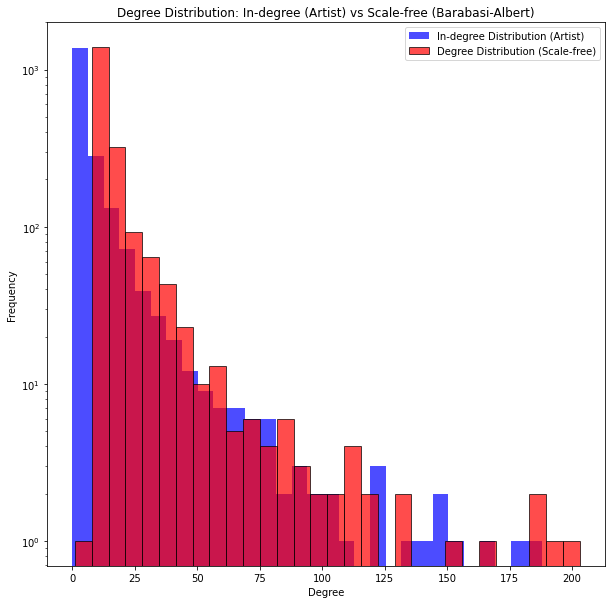

In [49]:
# Set size of figure
plt.figure(figsize=(10, 10))

# Histogram of Artist In-degree Distribution vs Scale-free degree
plt.hist(
    S_in_degree_values, 
    bins=30, 
    alpha=0.7, 
    label="In-degree Distribution (Artist)", 
    color="blue"
)

# Histogram of Out-degree Distribution
plt.hist(
    SFG_degree_values, 
    bins=30, 
    alpha=0.7, 
    label="Degree Distribution (Scale-free)", 
    color="red",
    edgecolor="black"
)

# Settings of axis/plot
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')
plt.legend()
plt.title("Degree Distribution: In-degree (Artist) vs Scale-free (Barabasi-Albert)")
plt.show()

As shown by the histograms above, the scale-free network simulates the real-world artist network very well. 

One of the key aspects of scale-free networks is _'preferential attachment'_ where new nodes (_artists_) tend to connect to existing nodes (Famous legacy artists).

This in turn leads to the formation of hubs, and is known as the _"rich-get-richer"_ mechanism.

If we think about this in more concrete matters: Dolly Parton has been a very well-known Country artist for decades now. It makes sense that whenever a singer with similar vocals, music or fashion style will pay homage to Parton, but only in an out-going reference.  

##### 2.2.4 Who are the top 5 most connected performers?

##### In-degree
The artists with the highest in-degree, are expected to be well-known artist from previous decades with massive influence on the genre, such as Dolly Parton and Willie Nelson:

In [50]:
i = 1
for node, in_degree in S_sorted_in_degree[:5]:
    idx = f"{i}. "
    name = f"{node}"
    degree = f"{in_degree}"

    line = [idx, name, degree]
    print("{: >4} {: <18}: {:}".format(*line))
    i = i+1

 1.  Willie Nelson     : 188
 2.  Johnny Cash       : 179
 3.  Elvis Presley     : 167
 4.  Dolly Parton      : 152
 5.  George Jones      : 146


As predicted, all of the 5 artist are huge in the American Country music halls of fame. Also, these are all artist with many decades of massive musical influence. The fact that 3 out of the 5 of them are deceased, they will most likely continue to grow their heritage through new artists. 

##### Out-degree
The artists with the highest out-degree, might be artists who have been in multiple bands over the years. 

Perhaps their wikipedia pages cover their musical influence from other artists:

In [51]:
i = 1
for node, out_degree in S_sorted_out_degree[:5]:
    idx = f"{i}. "
    name = f"{node}"
    degree = f"{out_degree}"
    length = f"{S.nodes()[node].get('length_of_content')}"

    line = [idx, name, degree, length]
    print("{: >4} {: <17} degree : {: <5} Length : {: <4}".format(*line))
    i = i+1

 1.  Hillary Lindsey   degree : 100   Length : 5374
 2.  Pam Tillis        degree : 83    Length : 10173
 3.  Randy Travis      degree : 76    Length : 16113
 4.  Vince Gill        degree : 72    Length : 13724
 5.  Patty Loveless    degree : 69    Length : 10394


If we look at the wikipedia page of Hillary Lindsey, we will find that she has had a long career of co-writing songs with other artists. This list turns out to be rather cumbersome which explains her very high out-degree. Without looking too much into the others on this list it might be a fair assumption, that musicians with many outgoing references have a history of songwriting or producing with other known artists. 

##### 2.2.5 What are the 10 pages with the longest wiki entries?

In [52]:
# Access the 'length_of_content' for all nodes
length_of_content_dict = nx.get_node_attributes(S, 'length_of_content')

# Sort the nodes by 'length_of_content' in descending order
sorted_nodes = sorted(
    length_of_content_dict.items(), 
    key=lambda x: x[1], 
    reverse=True
)

# Get the top 10 nodes
top_10_nodes = sorted_nodes[:10]

# top_10_nodes contains tuples of (node, length_of_content)
i = 1
for node, length_of_content in top_10_nodes:
    idx = f"{i}. "
    name = f"{node}"
    length = f"{length_of_content}"
    
    line = [idx, name, length]
    print("{: >4} {: <18}: {:}".format(*line))
    i = i+1

 1.  Beyoncé           : 62853
 2.  Taylor Swift      : 56429
 3.  Miley Cyrus       : 51262
 4.  Justin Bieber     : 50694
 5.  Carrie Underwood  : 45243
 6.  Justin Timberlake : 44779
 7.  Demi Lovato       : 44012
 8.  Bob Dylan         : 41141
 9.  Ed Sheeran        : 36312
10.  Alabama           : 34386


This list is a bit suprising - and then again not so much. 

Not so suprissing is that 7 out of the 10 artists are rather young and extremely popular artists in the modern music scene. 
This means that a lot of young fans, who are bit tech-savy, can edit their wikipedia pages with the latest gossip and musical achievements.    

However, it might be a bit suprising to find singers such as Justin Bieber, Justin Timberlake and Ed Sheeran on a Country music artist list when they are very popular pop-music artists. Also, the no. 1, Beyoncé has not had much connection to the country music scene before her recently published album featuring country inspired hits and featuring no. 3 on the list, Miley Cyrus. 

## Exercises Part 3: Visualizing the networks

### 3.1 Convert directed graph to undirected graph
For the sake of the visualisation, we may convert our network to an undirected graph.

In [53]:
# Use build-in function for converting from directed to undirected graph
DS = S.to_undirected()

### 3.2 Draw the graph using Kamada Kawai Algorithm

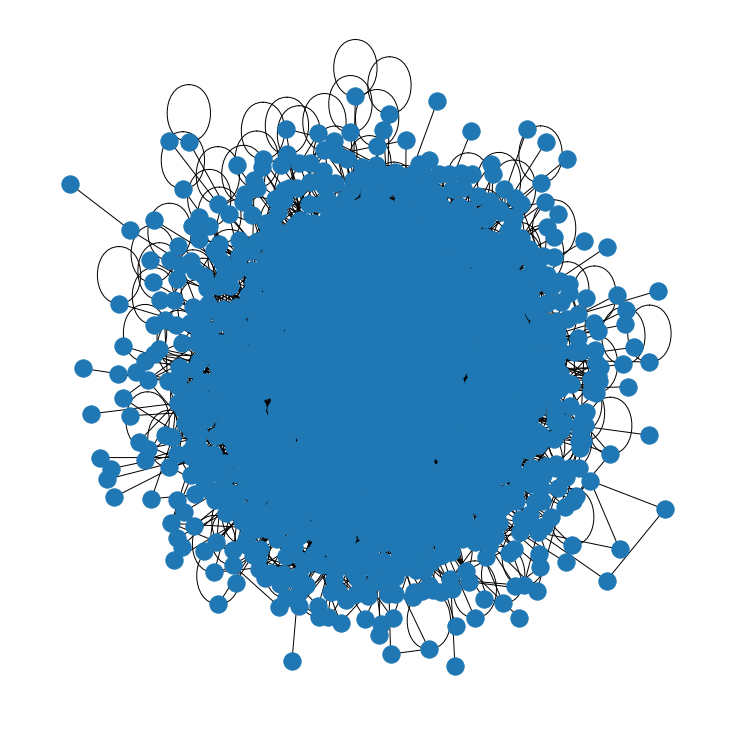

In [54]:
# Set size of figure
plt.figure(figsize=(10, 10))

# Quick Sketch without parameters or special features
nx.draw(DS, pos = nx.kamada_kawai_layout(DS))

#### 3.2.1 Set up your plot so that node-size depends on the node degree

In [55]:
# Get all degrees in order with the nodes
DS_degrees = sorted(DS.degree, key=lambda x: x[1], reverse=True)
DS_degree_values = [x[1] for x in DS_degrees]

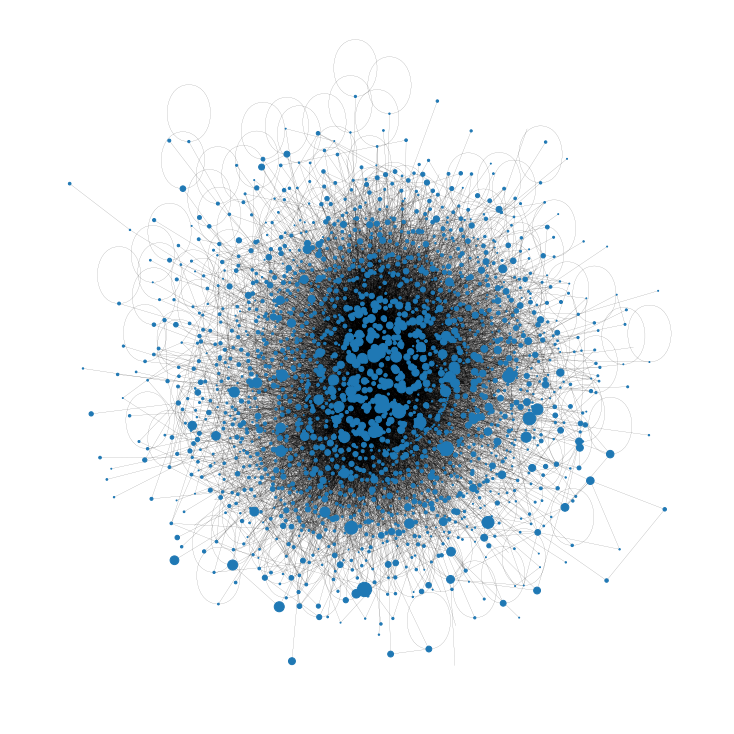

In [56]:
# Set size of figure
plt.figure(figsize=(10, 10))

# Sketch out the with node sizes based on degree 
nx.draw(
    DS, 
    pos = nx.kamada_kawai_layout(DS),
    node_size = DS_degree_values,
    width = 0.1
)

#### 3.2.2 Set up your plot so that node-color depends on the length of the nodes' content attribute 

In [57]:
# Remove self-loops in order to make the final plot prettier.
DS.remove_edges_from(list(nx.selfloop_edges(DS)))

Save graph for in path for later use

In [58]:
# Folder to store the text files
cwd = os.getcwd()
folder_name = "saved_graphs"
folder_path = os.path.join(cwd, folder_name)
folder_path

'C:\\Users\\Aleksandar Lukic\\School\\02805_Social_Graphs_and_Interactions\\Exercise_solutions\\saved_graphs'

In [59]:
# Check if the folder exists, otherwise create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [67]:
# Create file path
file_path = os.path.join(folder_path, "country_musicians.gexf")

In [71]:
# save graph object to file
# pickle.dump(DS, open(file_path, 'wb'))
nx.write_gexf(DS, file_path)

In [73]:
# load graph object from file
G_loaded = nx.read_gexf(file_path)

# Test similarity:
print(G_loaded)
print(DS)

Graph with 2003 nodes and 14229 edges
Graph with 2003 nodes and 14229 edges


Helper functions for adjusting node size and color according to node properties

In [74]:
# Helper function for normalisation of attribute values to fit colormap [0 to 1]  
def normalise(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val) if max_val != min_val else 0.5

In [75]:
# Function to assign color to a node based on length of content
def color_nodes_by_length(G, cmap_name = 'viridis'):

    # Get the 'length_of_content' attribute for each node
    length_values = [G.nodes[node]['length_of_content'] for node in G.nodes if 'length_of_content' in G.nodes[node]]

    # Use the parsed name to fetch the colormap from library 
    cmap = colormaps[cmap_name]
    
    # Range for normalisation of the values
    min_length = min(length_values)
    max_length = max(length_values)

    # Map each node's 'length_of_content' value to a color gradiant
    node_colors = []
    for node in G.nodes:
        if 'length_of_content' in G.nodes[node]:
            normalised_value = normalise(G.nodes[node]['length_of_content'], min_length, max_length)
            node_colors.append(cmap(normalised_value))
        else:
            # If the node has no 'length_to_content' attribute, 
            # assign default color of black
            node_colors.append((0, 0, 0, 1))

    return node_colors

In [76]:
# Get node colors based on 'length' attribute
node_colors = color_nodes_by_length(DS, cmap_name = 'rainbow')

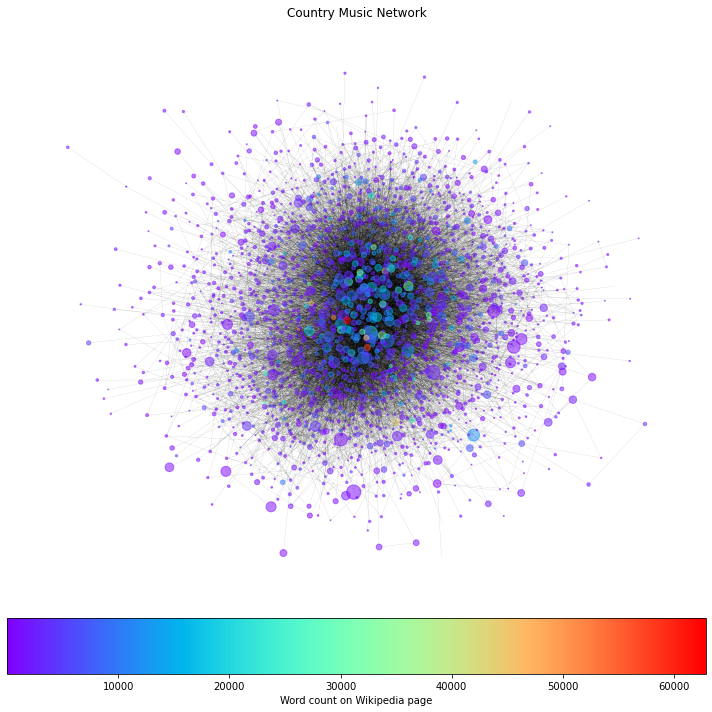

In [77]:
# Define figure size and gridspec layout
fig = plt.figure(figsize=(10, 10))

# Divide the figure into 10 equal rows
gs = fig.add_gridspec(10, 1)

# Graph plot (top 9/10 of the figure)
ax_graph = fig.add_subplot(gs[:9, 0])
nx.draw(
    DS,
    pos=nx.kamada_kawai_layout(DS),
    ax=ax_graph,  # Use the defined axis
    node_size=DS_degree_values,
    alpha=0.5,
    node_color=node_colors,
    width=0.1,
    with_labels=False
)

# Set title of plot
ax_graph.set_title("Country Music Network")

# Colorbar plot (bottom 1/10 of the figure)
ax_colorbar = fig.add_subplot(gs[9, 0])  # The bottom 1 row for the colorbar

# Colorbar code
vals = [DS.nodes[node]['length_of_content'] for node in DS.nodes if 'length_of_content' in DS.nodes[node]]
cmap = colormaps['rainbow']
norm = mpl.colors.Normalize(vmin=min(vals), vmax=max(vals))

# Create the colorbar on the designated axis
fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax_colorbar,
    orientation='horizontal',
    label='Word count on Wikipedia page'
)

# Adjust layout to ensure colorbar and graph are not overlapping
plt.tight_layout()
plt.show()